# Spotify Genre Classifier

## Setup

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk, path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy import stats
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import json

In [4]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [5]:
raw_data.head()

danceability   energy  key  loudness  mode  speechiness  acousticness  \
0         0.169  0.00433    6   -37.710     1       0.0330         0.988   
1         0.138  0.05090    4   -22.513     1       0.0431         0.941   
2         0.227  0.00482    8   -36.351     1       0.0360         0.993   
3         0.393  0.00710    3   -31.748     1       0.0571         0.995   
4         0.366  0.14500    6   -24.892     0       0.0378         0.926   

   instrumentalness  liveness  valence   tempo            type  \
0             0.308    0.0637   0.0359  82.592  audio_features   
1             0.926    0.1090   0.0372  87.037  audio_features   
2             0.912    0.1570   0.0731  70.684  audio_features   
3             0.887    0.1040   0.2520  71.203  audio_features   
4             0.483    0.3310   0.0749  94.159  audio_features   

                       id                                   uri  \
0  3OueD83BFjh2lCyhuEpXVF  spotify:track:3OueD83BFjh2lCyhuEpXVF   
1  722VEAitQPDKYkTe3UDlZK  spotify:track:722VEAitQPDKYkTe3UDlZK   
2  2EAgTVB2EdsMdqaqOk062L  spotify:track:2EAgTVB2EdsMdqaqOk062L   
3  3IRoeiTnEJ31WKMtcXShX1  spotify:track:3IRoeiTnEJ31WKMtcXShX1   
4  5hJrBqOLUnMXNjDlAX67aP  spotify:track:5hJrBqOLUnMXNjDlAX67aP   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/3OueD83BFjh2...   
1  https://api.spotify.com/v1/tracks/722VEAitQPDK...   
2  https://api.spotify.com/v1/tracks/2EAgTVB2EdsM...   
3  https://api.spotify.com/v1/tracks/3IRoeiTnEJ31...   
4  https://api.spotify.com/v1/tracks/5hJrBqOLUnMX...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/3Oue...       236147   
1  https://api.spotify.com/v1/audio-analysis/722V...       335093   
2  https://api.spotify.com/v1/audio-analysis/2EAg...       216284   
3  https://api.spotify.com/v1/audio-analysis/3IRo...       292360   
4  https://api.spotify.com/v1/audio-analysis/5hJr...       229000   

   time_signature    genre  
0               4  classic  
1               4  classic  
2               5  classic  
3               4  classic  
4               5  classic

In [6]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre'],
      dtype='object')

In [7]:
# now drop some features which have no importance for the ML task
raw_data.drop(["uri", "id", "track_href", "analysis_url", "type"], axis=1, inplace=True)

In [8]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre'],
      dtype='object')

In [9]:
raw_data.shape

(2583, 14)

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      2583 non-null   float64
 1   energy            2583 non-null   float64
 2   key               2583 non-null   int64  
 3   loudness          2583 non-null   float64
 4   mode              2583 non-null   int64  
 5   speechiness       2583 non-null   float64
 6   acousticness      2583 non-null   float64
 7   instrumentalness  2583 non-null   float64
 8   liveness          2583 non-null   float64
 9   valence           2583 non-null   float64
 10  tempo             2583 non-null   float64
 11  duration_ms       2583 non-null   int64  
 12  time_signature    2583 non-null   int64  
 13  genre             2583 non-null   object 
dtypes: float64(9), int64(4), object(1)
memory usage: 282.6+ KB


In [11]:
# remove samples with key == -1
befor = len(raw_data)
raw_data = raw_data[raw_data.key != -1]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 0


In [12]:
# remove samples where time_signature is out of bounds [3:7]
befor = len(raw_data)
raw_data = raw_data[(raw_data.time_signature >= 3) & (raw_data.time_signature <= 7)]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 36


In [13]:
raw_data.describe()

danceability       energy          key     loudness         mode  \
count   2547.000000  2547.000000  2547.000000  2547.000000  2547.000000   
mean       0.529639     0.531046     5.283863   -11.629449     0.564978   
std        0.210856     0.334828     3.533243     8.894141     0.495857   
min        0.061800     0.000707     0.000000   -44.526000     0.000000   
25%        0.388000     0.159000     2.000000   -16.245000     0.000000   
50%        0.534000     0.625000     5.000000    -8.043000     1.000000   
75%        0.692500     0.836000     8.000000    -5.077000     1.000000   
max        0.974000     0.998000    11.000000     0.496000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  2547.000000   2547.000000       2547.000000  2547.000000  2547.000000   
mean      0.099759      0.403065          0.245689     0.179053     0.394868   
std       0.102587      0.411257          0.372409     0.140529     0.255927   
min       0.024900      0.000002          0.000000     0.023400     0.028100   
25%       0.039450      0.019200          0.000000     0.094050     0.166000   
50%       0.050000      0.174000          0.000747     0.121000     0.374000   
75%       0.108500      0.904000          0.613500     0.224000     0.603500   
max       0.944000      0.996000          0.982000     0.972000     0.978000   

             tempo   duration_ms  time_signature  
count  2547.000000  2.547000e+03     2547.000000  
mean    117.138169  2.531548e+05        3.911268  
std      30.628928  1.098976e+05        0.355601  
min      47.362000  5.292900e+04        3.000000  
25%      92.668000  1.819850e+05        4.000000  
50%     117.486000  2.257730e+05        4.000000  
75%     138.219000  2.910295e+05        4.000000  
max     213.087000  1.215573e+06        5.000000

In [14]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
raw_data.groupby(raw_data["genre"]).describe()["energy"]

count      mean       std       min      25%      50%      75%    max
genre                                                                         
classic  492.0  0.074837  0.092985  0.000707  0.01270  0.03855  0.10100  0.606
edm      496.0  0.846556  0.095914  0.435000  0.78575  0.86100  0.92500  0.998
hiphop   524.0  0.671134  0.141285  0.248000  0.56575  0.67100  0.78525  0.952
jazz     524.0  0.262866  0.186547  0.007560  0.10975  0.22200  0.39800  0.783
rock     511.0  0.795394  0.156814  0.099300  0.70900  0.84600  0.91300  0.998

### Plots

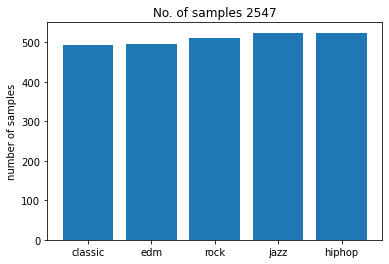

In [15]:
sorted_list = raw_data["genre"].value_counts().sort_values()
labels = sorted_list.index.tolist()
values = sorted_list.tolist()

plt.bar(labels, values)
plt.title(f"No. of samples {raw_data.shape[0]}")
plt.ylabel("number of samples")
plt.show()

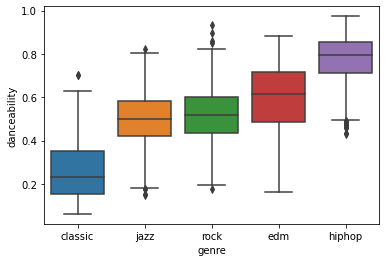

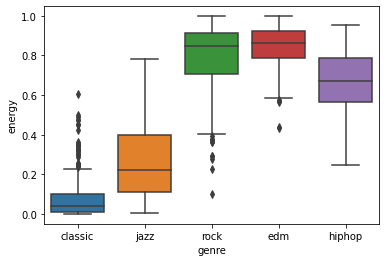

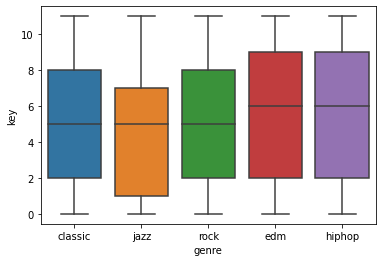

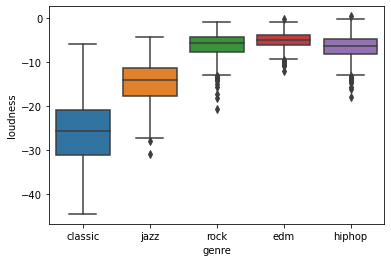

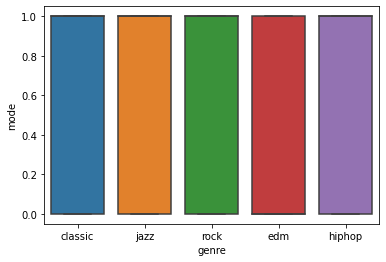

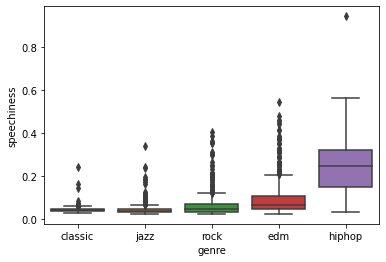

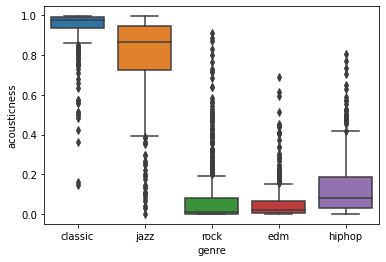

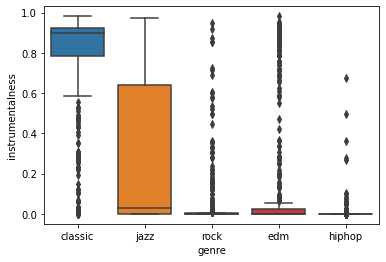

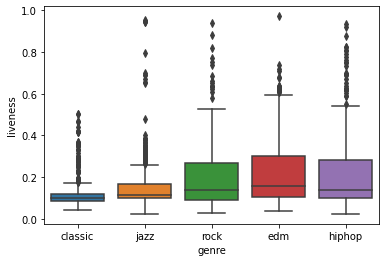

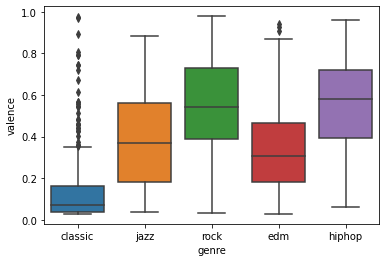

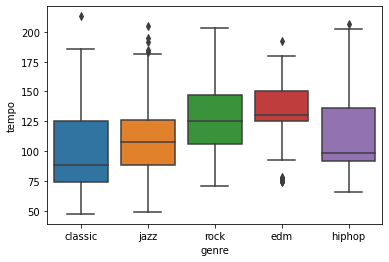

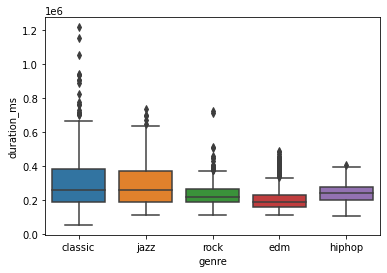

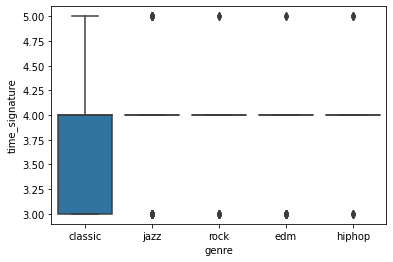

In [16]:
for feature in raw_data.iloc[:,:13].columns:
    sns.boxplot(x="genre", y=feature, data=raw_data)
    plt.show()

In [17]:
raw_data.iloc[:,:13].corr()

danceability    energy       key  loudness      mode  \
danceability          1.000000  0.503387  0.061453  0.592373 -0.094026   
energy                0.503387  1.000000  0.081762  0.885060 -0.087304   
key                   0.061453  0.081762  1.000000  0.059056 -0.181924   
loudness              0.592373  0.885060  0.059056  1.000000 -0.109974   
mode                 -0.094026 -0.087304 -0.181924 -0.109974  1.000000   
speechiness           0.438121  0.314614  0.080833  0.317084 -0.071297   
acousticness         -0.558688 -0.908342 -0.077332 -0.818370  0.067043   
instrumentalness     -0.493348 -0.585985 -0.021487 -0.690924  0.070763   
liveness              0.097252  0.270205  0.058754  0.256329 -0.029034   
valence               0.603751  0.486132  0.019365  0.510027 -0.015412   
tempo                 0.087938  0.381870  0.025432  0.351275 -0.038727   
duration_ms          -0.227813 -0.223306 -0.035558 -0.226735  0.046172   
time_signature        0.259476  0.245033  0.015053  0.249251 -0.011839   

                  speechiness  acousticness  instrumentalness  liveness  \
danceability         0.438121     -0.558688         -0.493348  0.097252   
energy               0.314614     -0.908342         -0.585985  0.270205   
key                  0.080833     -0.077332         -0.021487  0.058754   
loudness             0.317084     -0.818370         -0.690924  0.256329   
mode                -0.071297      0.067043          0.070763 -0.029034   
speechiness          1.000000     -0.372817         -0.323239  0.149792   
acousticness        -0.372817      1.000000          0.605265 -0.243612   
instrumentalness    -0.323239      0.605265          1.000000 -0.208678   
liveness             0.149792     -0.243612         -0.208678  1.000000   
valence              0.264829     -0.442166         -0.495763  0.117262   
tempo                0.068869     -0.347903         -0.224552  0.081312   
duration_ms         -0.122091      0.244916          0.271341 -0.101143   
time_signature       0.115105     -0.241134         -0.212260  0.062828   

                   valence     tempo  duration_ms  time_signature  
danceability      0.603751  0.087938    -0.227813        0.259476  
energy            0.486132  0.381870    -0.223306        0.245033  
key               0.019365  0.025432    -0.035558        0.015053  
loudness          0.510027  0.351275    -0.226735        0.249251  
mode             -0.015412 -0.038727     0.046172       -0.011839  
speechiness       0.264829  0.068869    -0.122091        0.115105  
acousticness     -0.442166 -0.347903     0.244916       -0.241134  
instrumentalness -0.495763 -0.224552     0.271341       -0.212260  
liveness          0.117262  0.081312    -0.101143        0.062828  
valence           1.000000  0.118482    -0.149642        0.233528  
tempo             0.118482  1.000000    -0.151641        0.032138  
duration_ms      -0.149642 -0.151641     1.000000       -0.092155  
time_signature    0.233528  0.032138    -0.092155        1.000000

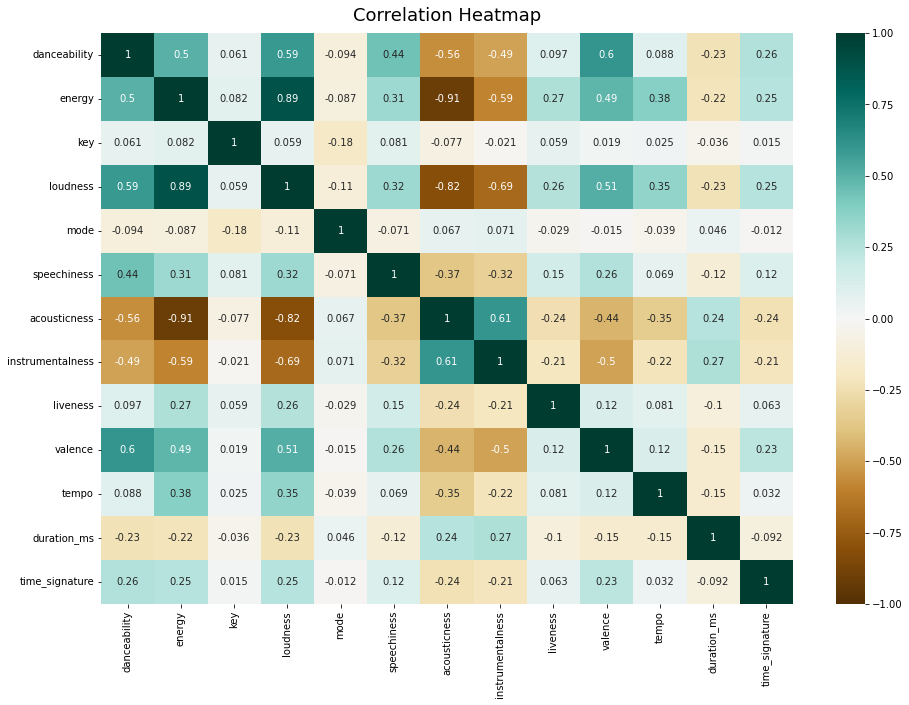

In [18]:
fig = plt.figure()
heatmap = sns.heatmap(raw_data.iloc[:,:13].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

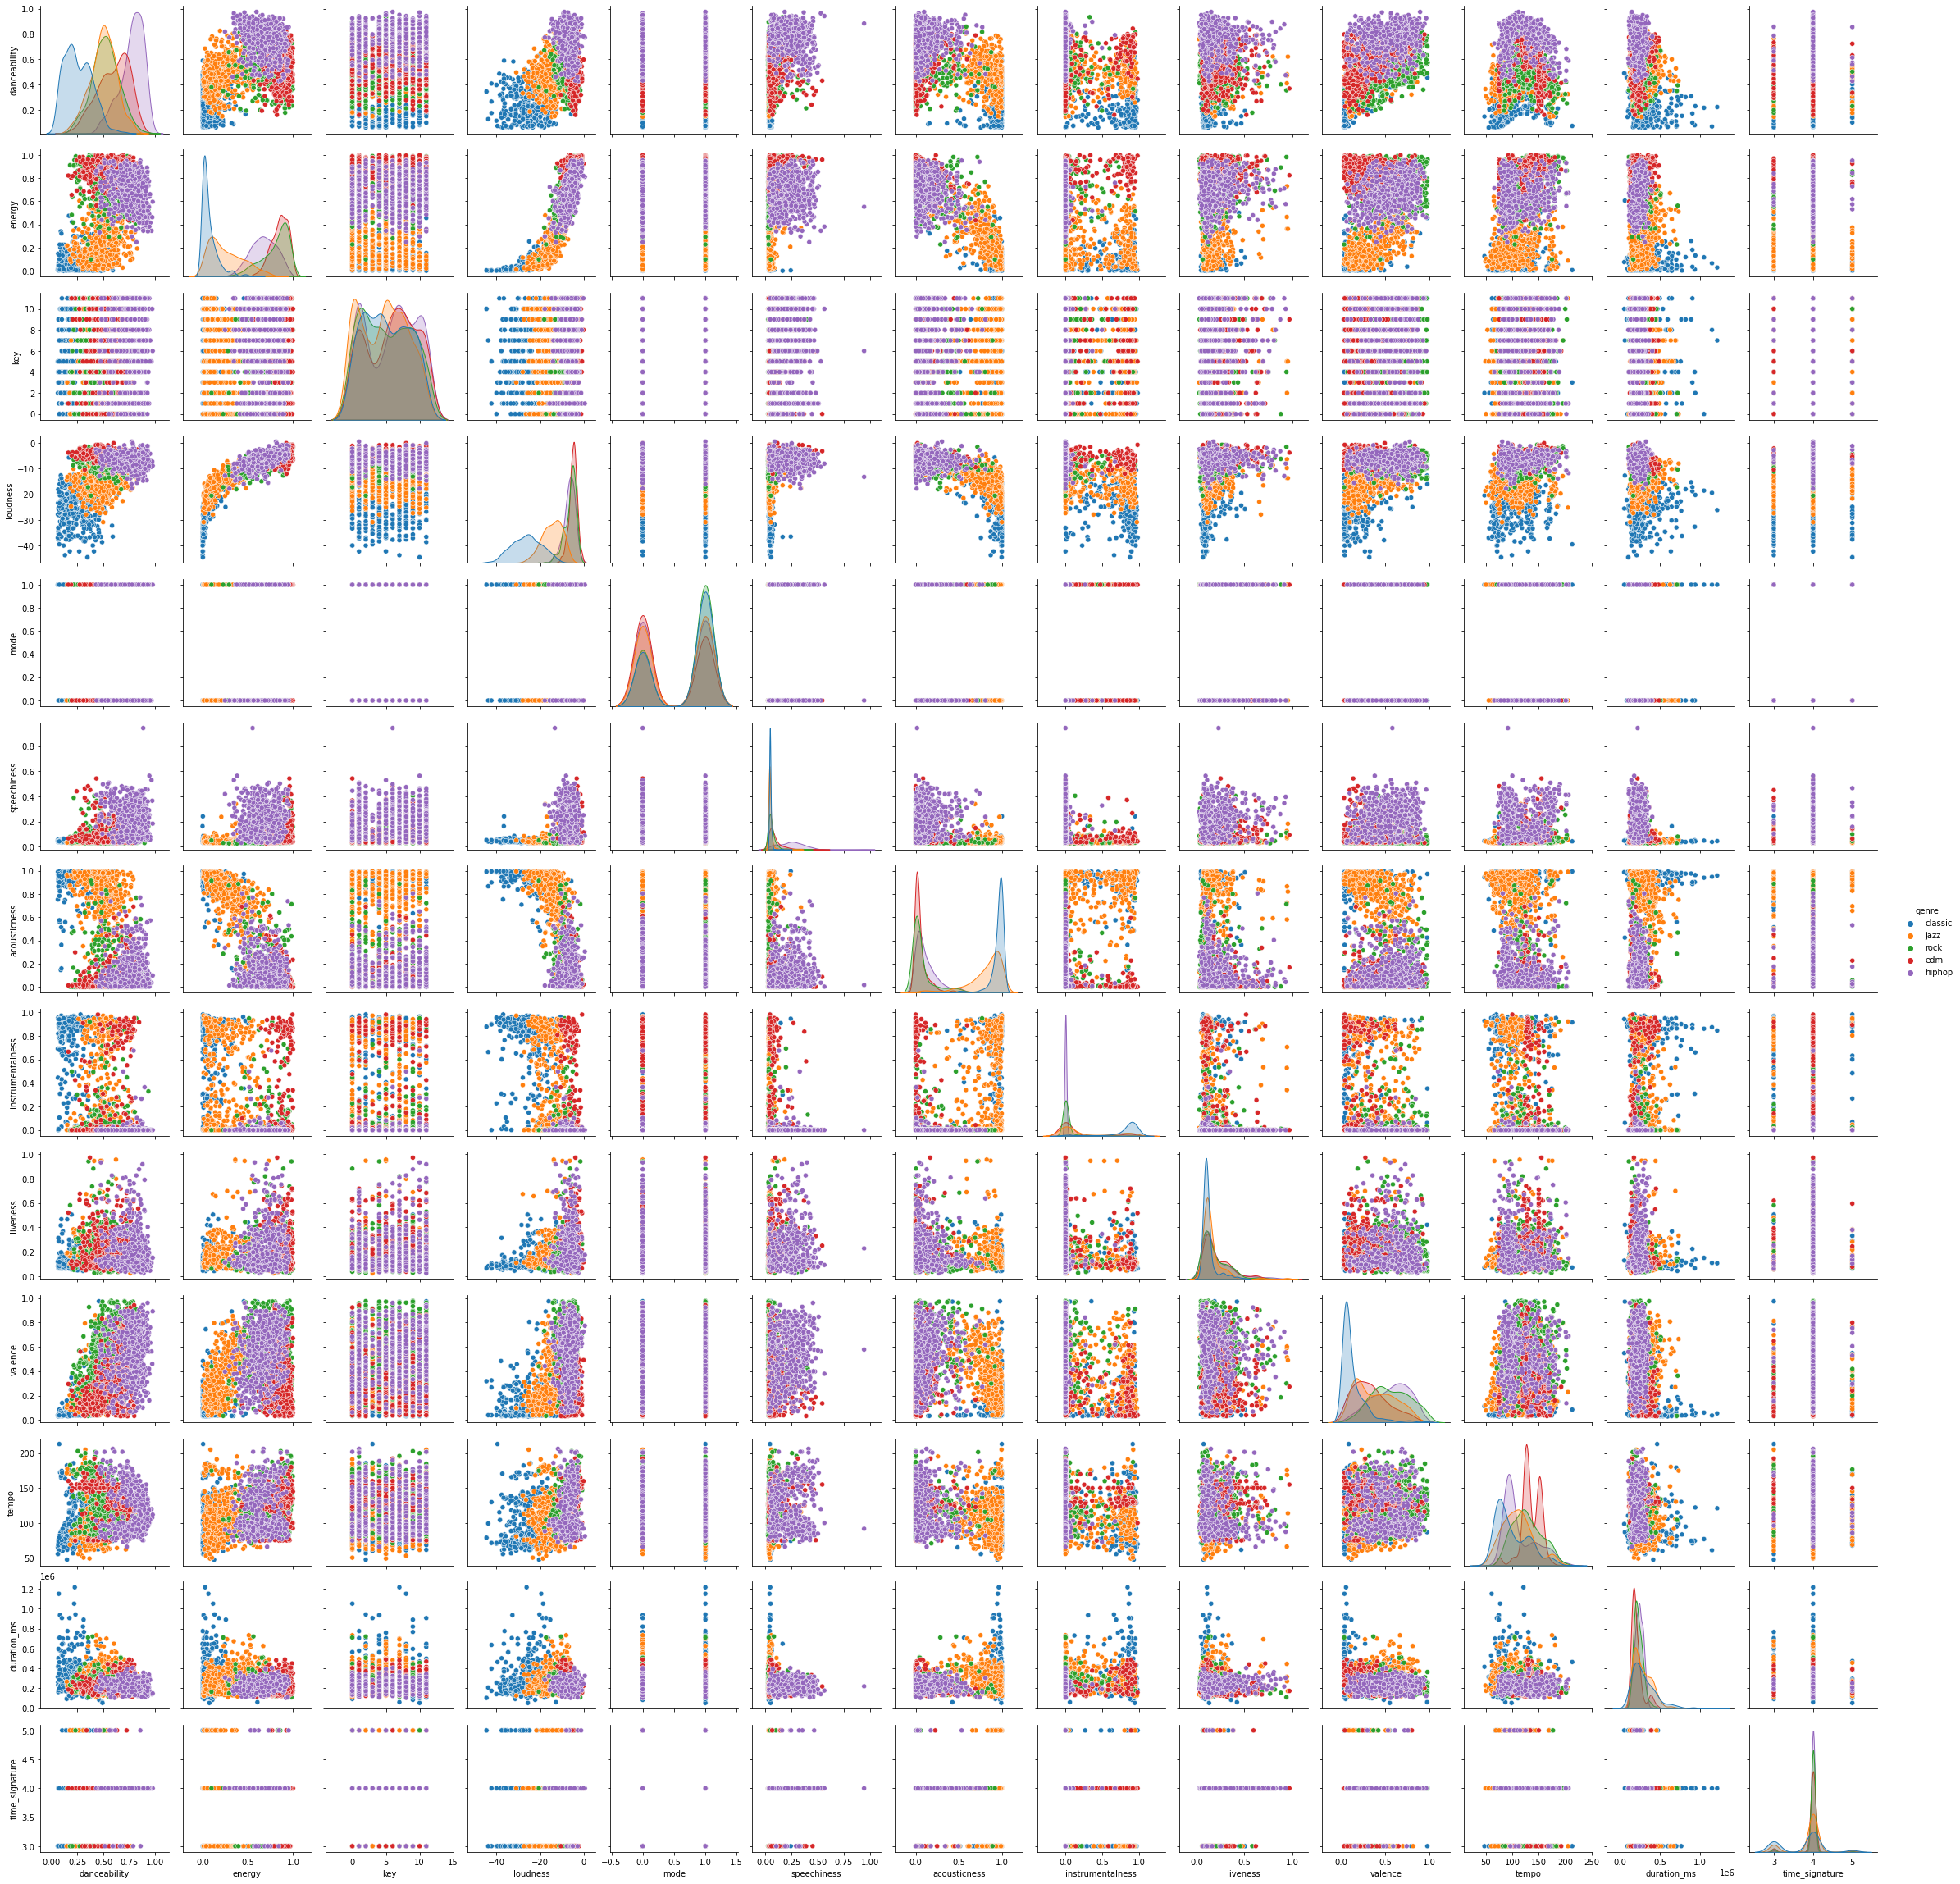

In [19]:
sns.pairplot(data=raw_data, hue="genre")

## Preprocessing

### Train test split

In [20]:
categorical_features = {'key', 'mode', 'time_signature'}
numeric_features = set(raw_data.columns) - categorical_features - {"genre"}

numeric_features = list(numeric_features)
categorical_features = list(categorical_features)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(raw_data.iloc[:,:13], raw_data.genre, test_size=0.33, stratify=raw_data.genre)
data = {
    "x_train": x_train,
    "x_test": x_test,
    "y_train": y_train,
    "y_test": y_test,
    "features": numeric_features + categorical_features,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "target": "genre"
}

### Remove correlated features

In [22]:
def find_correlated_features(df:pd.DataFrame, threshold:float) -> list:
    correlation_matrix = df.corr().abs()
    avg_correlation = correlation_matrix.mean(axis = 1)
    up = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    drop = list()
        
    for row in range(len(up)-1):
        for col in range (row + 1, len(up)):
            if(correlation_matrix.iloc[row, col] >= threshold):
                if(avg_correlation.iloc[row] > avg_correlation.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop = list(set(drop)) 
    dropcols_names = list(df.columns[[item for item in drop]])
    
    return dropcols_names

/var/folders/70/ck9tkfr53jz8kss1cbvrk59r0000gn/T/ipykernel_65172/3844288973.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  up = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


Drop these correlated features: ['energy']


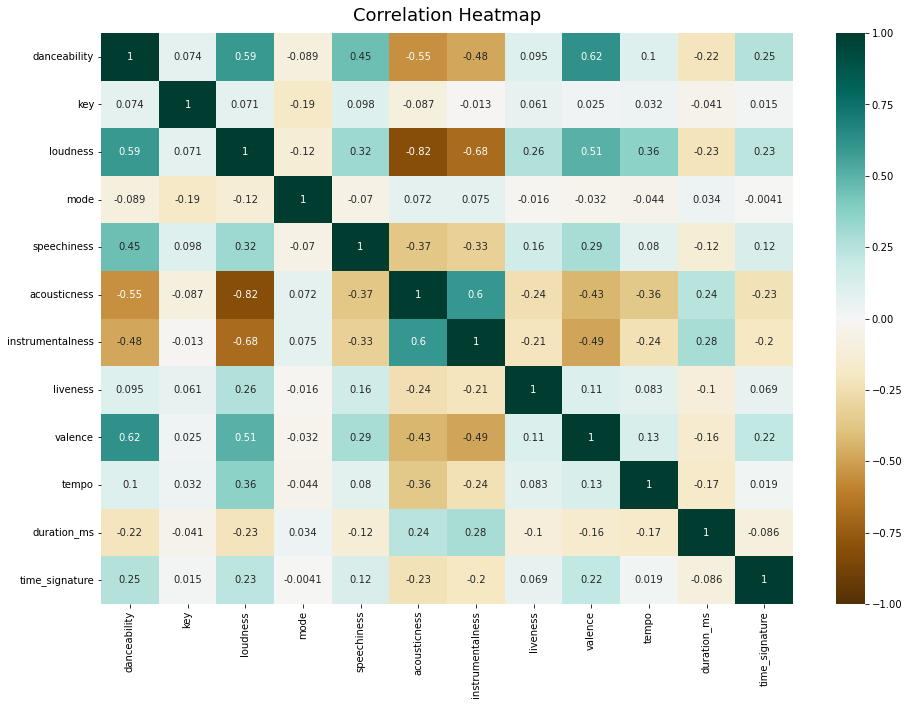

In [23]:
correlated_features = find_correlated_features(data["x_train"], 0.9)

print(f'Drop these correlated features: {correlated_features}')

data["x_train"].drop(correlated_features, axis=1, inplace=True)
[data["features"].remove(f) for f in correlated_features]
for feature in correlated_features:
    if feature in data["categorical_features"]:
        data["categorical_features"].remove(feature)
    if feature in data["numeric_features"]:
        data["numeric_features"].remove(feature)

fig = plt.figure()
heatmap = sns.heatmap(data["x_train"].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

### Normalization

In [19]:
scaler = StandardScaler()
data["x_train"][data["numeric_features"]] = scaler.fit_transform(data["x_train"][data["numeric_features"]])
data["x_train"].describe()

danceability          key      loudness         mode   speechiness  \
count  1.002000e+03  1002.000000  1.002000e+03  1002.000000  1.002000e+03   
mean   1.701899e-16     5.332335 -2.216014e-17     0.546906  1.063687e-16   
std    1.000499e+00     3.538899  1.000499e+00     0.498044  1.000499e+00   
min   -2.182170e+00     0.000000 -3.954340e+00     0.000000 -7.339732e-01   
25%   -6.725801e-01     2.000000 -3.845900e-01     0.000000 -5.774943e-01   
50%   -9.260765e-03     5.000000  3.976347e-01     1.000000 -4.630691e-01   
75%    7.115303e-01     8.000000  6.964464e-01     1.000000  7.531622e-02   
max    2.095641e+00    11.000000  1.240341e+00     1.000000  8.253785e+00   

       acousticness  instrumentalness      liveness       valence  \
count  1.002000e+03      1.002000e+03  1.002000e+03  1.002000e+03   
mean  -2.127373e-17      1.772811e-18 -6.382120e-17 -4.254747e-17   
std    1.000499e+00      1.000499e+00  1.000499e+00  1.000499e+00   
min   -8.908857e-01     -6.647477e-01 -1.064726e+00 -1.449404e+00   
25%   -8.661475e-01     -6.647477e-01 -6.068384e-01 -9.090934e-01   
50%   -6.169379e-01     -6.619833e-01 -4.142007e-01 -4.784094e-02   
75%    1.169948e+00      1.062374e+00  3.450769e-01  8.095494e-01   
max    1.578397e+00      1.994030e+00  5.225673e+00  2.145843e+00   

              tempo   duration_ms  time_signature  
count  1.002000e+03  1.002000e+03     1002.000000  
mean  -3.722904e-17  1.648714e-16        3.932136  
std    1.000499e+00  1.000499e+00        0.336559  
min   -2.301980e+00 -1.513921e+00        3.000000  
25%   -7.853297e-01 -6.258548e-01        4.000000  
50%   -5.407066e-02 -2.743278e-01        4.000000  
75%    8.430032e-01  2.913389e-01        4.000000  
max    2.798543e+00  7.640441e+00        5.000000

### Remove outliers

## Model Selection

### PCA

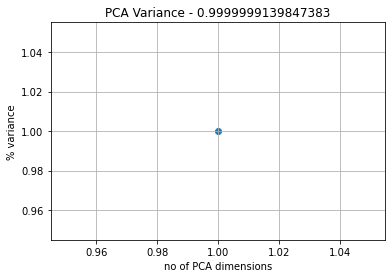

In [24]:
pca_variance_threshold = .9
pca = PCA(pca_variance_threshold)
pca.fit(data["x_train"][data["numeric_features"]])

plt.scatter(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.title(f"PCA Variance - {np.sum(pca.explained_variance_ratio_)}")
plt.xlabel("no of PCA dimensions") 
plt.ylabel("% variance")
plt.show()

In [25]:
test_pca_transform = data["x_train"].copy()

pca_components = pca.transform(test_pca_transform[data["numeric_features"]])
cols = [f"PC{x}" for x in range(1, len(pca.explained_variance_ratio_)+1)]
test_pca_transform_new = pd.DataFrame(pca_components, columns=cols, index=data["x_train"].index)
test_pca_transform = pd.concat([test_pca_transform_new, test_pca_transform[data["categorical_features"]]], axis=1)
test_pca_transform

PC1  mode  time_signature  key
2430 -50337.142136     1               4    9
1500 -43280.143405     0               4    2
1709 -35550.144959     0               4    8
2389 -60338.141785     0               4    6
2507 -39258.146136     0               4   10
...            ...   ...             ...  ...
509   95101.858842     1               4    0
410   54021.858939     1               3    0
738   25794.854437     0               4    5
835   32444.857416     1               4    8
900  -62565.143112     0               4   10

[1706 rows x 4 columns]

### Nested Cross Validation 

In [27]:
estimators = {}

estimators['knn'] = {
    'estimator': KNeighborsClassifier(),
    'paramGrid': {
            'n_neighbors' : [x for x in range(3, 30) if x % len(set(data["y_train"])) != 0],
            'weights' : ['uniform', 'distance'],
            'metric' : ['euclidean', 'manhattan']
            }
}

estimators['randomForest'] = {
    'estimator': RandomForestClassifier(),
    'paramGrid': {
            'max_depth': [10, 20, 30, 40],
            'max_features': [5, 13],
            'min_samples_leaf': [3, 4, 5, 8],
            'min_samples_split': [8, 12, 16],
            'n_estimators': [1000], #[500, 1000, 3000, 5000]
           } 
}

estimators['svc'] = {
    'estimator': SVC(probability=True),
    'paramGrid': [
            {"kernel": ["rbf"], "gamma": np.float_power(3, range(-8,-2)), "C": np.float_power(3, range(0,8))},
            {"kernel": ["linear"], "C": np.float_power(3, range(0,8))},
           ]
}

results = dict()
seed = 12345

for estimatorKey, estimatorValue in estimators.items():
    results[estimatorKey] = []
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for train_index, test_index in outer_cv.split(X=data["x_train"], y=data["y_train"]):
        X_train, X_test = data["x_train"].iloc[train_index,:], data["x_train"].iloc[test_index,:]
        y_train, y_test = data["y_train"].iloc[train_index], data["y_train"].iloc[test_index]

        grid_search = GridSearchCV(
            estimator = estimatorValue['estimator'], 
            param_grid = estimatorValue['paramGrid'], 
            cv = inner_cv, 
            n_jobs = -1, 
            verbose = 1
        )

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)

        res = {}
        res["acc_score"] = acc_score
        res["best_params"] = json.dumps(grid_search.best_params_)
        res["best_estimator"] = grid_search.best_estimator_

        print(type(grid_search.best_estimator_))
        
        results[estimatorKey].append(res)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 88 candidates, totalling 440 fits
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 88 candidates, totalling 440 fits
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 88 candidates, totalling 440 fits
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 88 candidates, totalling 440 fits


KeyboardInterrupt: 

### Feature Selection forward

In [24]:
for i in range(1, len(data["features"])):
    svc = SVC(C=10)
    sfs_forward = SequentialFeatureSelector(
        svc, n_features_to_select=i, direction="forward"
    ).fit(data["x_train"], data["y_train"])

    feature_names = list(sfs_forward.get_feature_names_out())
    svc.fit(data["x_train"][feature_names], data["y_train"])
    print(f'No. of features: {len(feature_names)}, Features: {feature_names}, Score: {svc.score(data["x_test"][feature_names], data["y_test"])}')

No. of features: 1, Features: ['acousticness'], Score: 0.35020242914979755
No. of features: 2, Features: ['danceability', 'acousticness'], Score: 0.3360323886639676
No. of features: 3, Features: ['danceability', 'acousticness', 'valence'], Score: 0.32388663967611336
No. of features: 4, Features: ['danceability', 'acousticness', 'valence', 'tempo'], Score: 0.1882591093117409
No. of features: 5, Features: ['danceability', 'loudness', 'acousticness', 'valence', 'tempo'], Score: 0.1882591093117409
No. of features: 6, Features: ['danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo'], Score: 0.1882591093117409
No. of features: 7, Features: ['danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'], Score: 0.2165991902834008
No. of features: 8, Features: ['danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms'], Score: 0.1882591093117409
No. of features: 9, Features: 

KeyboardInterrupt: 